This tensor example is taken from https://www.tensorflow.org/tutorials/audio/simple_audio#run_inference_on_an_audio_file, but adapted for my use case.

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display
features=[]
labels=[]

Read dataset and shuffle.

In [55]:
dataset_path: str = "C:\\Users\\rclendening\\researchData\\Training_Data_NM_RS"
data_dir = pathlib.Path(dataset_path)

drones = np.array(tf.io.gfile.listdir(str(data_dir)))
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
train_files=filenames
print("Total num of samples: ", num_samples)
print("Number of examples per label:", len(tf.io.gfile.listdir(str(data_dir / drones[0]))))
print("Example file tensor: ", filenames[0])
print(drones)
print(train_files)

Total num of samples:  871
Number of examples per label: 239
Example file tensor:  tf.Tensor(b'C:\\Users\\rclendening\\researchData\\Training_Data_NM_RS\\Phantom_4_Pro_V2\\PHANTOM4-FT-D-3405_20191126.wav', shape=(), dtype=string)
['IF1200' 'Matrice_600' 'Mavic_Pro' 'Noise' 'Phantom_4_Pro_V2']


KeyboardInterrupt: 

In [6]:
test_file = tf.io.read_file("C:\\Users\\rclendening\\researchData\\Training_Data_NM_RS\\IF1200\\d301sA1r01p0120210823_6.wav")
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([480000, 1])

In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio,axis=-1)

In [8]:
def get_label(file_path):
    parts=tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]
get_label("C:\\Users\\rclendening\\researchData\\Training_Data_NM_RS\\IF1200\\d301sA1r01p0120210823_6.wav")

<tf.Tensor: shape=(), dtype=string, numpy=b'IF1200'>

In [89]:
def split_audio(waveData,labelName, sampleFreq,startTime, frame_duration):
    features=[]
    label=[]
    duration = waveData.shape[0]/sampleFreq
    frame_dur= frame_duration*sampleFreq
    t1 = startTime*sampleFreq
    t2 = t1+frame_dur
    frame_dur=int(frame_dur)
    t1= int(t1)
    t2=int(t2)
    while t2 < (duration * 1000) - frame_dur:
        split = waveData[t1:t2]
        t1 = t2
        t2 = t2 + frame_duration
        split=tf.reshape(split,frame_dur)
        split=get_spectrogram(split,frame_dur)
        features.extend(split)
        label.append(labelName)
    return features,labels

def create_dataset(train_files):
    i=0
    features=[]
    labels=[]
    for x in train_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        x=str(x)
        label = x.split('\\')
        label=label[10]

        test_audio = test_audio[0: test_audio.shape[0]-test_audio.shape[0] % 8000] #trim to nearest second
        features,labels=split_audio(test_audio,label,int(sampleRate),1, 0.5)
        i=i+1
    return features,labels
features=[]
labels=[]
features,labels=create_dataset(train_files)





TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 12000.5

TypeError: `x` and `y` must have the same dtype, got tf.float32 != tf.int32.

Traceback (most recent call last):
  File "_pydevd_bundle\pydevd_cython_win32_39_64.pyx", line 1035, in _pydevd_bundle.pydevd_cython_win32_39_64.PyDBFrame.trace_dispatch
  File "C:\Program Files\JetBrains\PyCharm 2021.3.2\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 144, in cmd_step_over
    if _is_inside_jupyter_cell(frame, pydb):
  File "C:\Program Files\JetBrains\PyCharm 2021.3.2\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 209, in _is_inside_jupyter_cell
    if is_cell_filename(filename):
  File "C:\Program Files\JetBrains\PyCharm 2021.3.2\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 220, in is_cell_filename
    ipython_shell = get_ipython()
NameError: name 'get_ipython' is not defined


In [11]:
def get_waveform_and_label(file_path):
    label= get_label(file_path)
    audio_binary =tf.io.read_file(file_path)
    waveform =decode_audio(audio_binary)
    return waveform, label
w,l=get_waveform_and_label("C:\\Users\\rclendening\\researchData\\Training_Data_NM_RS\\IF1200\\d301sA1r01p0120210823_6.wav")
print(l)


tf.Tensor(b'IF1200', shape=(), dtype=string)


In [31]:
AUTOTUNE= tf.data.AUTOTUNE
files_ds =tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
len(waveform_ds)

871

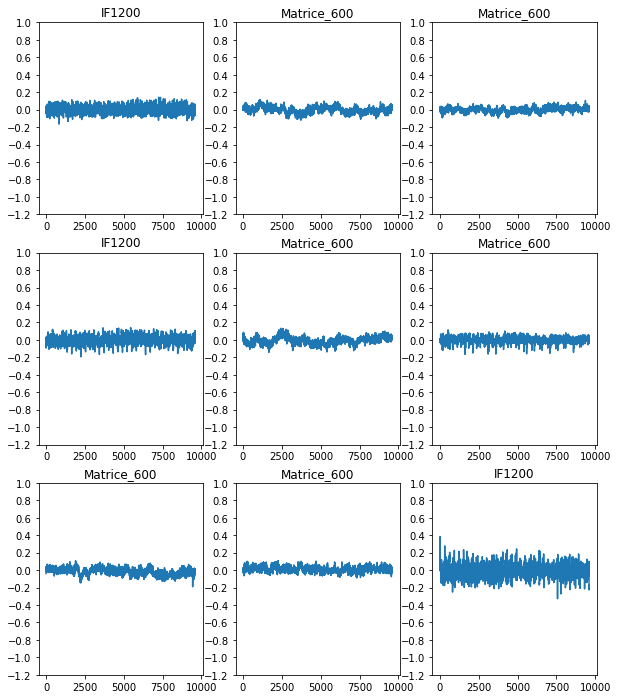

In [175]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [58]:
def get_spectrogram(waveform,length):
  # Zero-padding for an audio waveform with less than length samples
  input_len = length
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [length] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=128, frame_step=64)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram
len(waveform_ds)
test_file = tf.io.read_file("C:\\Users\\rclendening\\researchData\\Training_Data_NM_RS\\IF1200\\d301sA1r01p0120210823_6.wav")
test_audio, _ = tf.audio.decode_wav(contents=test_file)
tes=waveform_ds.take(1)
test_audio.shape
a=tf.reshape(test_audio[6000:10000],[4000])
s=get_spectrogram(a,5000)



tf.Tensor(
[ 0.02062988 -0.13842773  0.19763184 ...  0.00509644 -0.00561523
 -0.11138916], shape=(4000,), dtype=float32)


In [34]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=8000))

TypeError: get_spectrogram() missing 1 required positional argument: 'length'

In [25]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)



plot_spectrogram(test_audio.numpy(),axes[1])
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, len(spectrogram)])

axes[1].set_title('Spectrogram')
plt.show()

InvalidArgumentError: ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [5000,1] vs. shape[1] = [0,4999] [Op:ConcatV2] name: concat

8000
